In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import os
import PIL
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets, layers, models
from keras_visualizer import visualizer

import pathlib
import time
import datetime
import pickle
import random

os.environ['PYTHONHASHSEED']=str(123)
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [3]:
# Test to see whether you have all necessary libraries for GPU support
# If so, this should output a list with at least one GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

If a GPU is present, the next cell should be run to limit the amount of allocated memory on the GPU only to that which is necessary.

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Organizing the data

In [5]:
train_dir = 'data/kaggle dataset/chest_xray/train'
test_dir = 'data/kaggle dataset/chest_xray/test'
val_dir = 'data/kaggle dataset/chest_xray/val'

In [6]:
train_norm_dir = os.path.join(train_dir, 'NORMAL')
train_pneu_dir = os.path.join(train_dir, 'PNEUMONIA')
val_norm_dir = os.path.join(val_dir, 'NORMAL')
val_pneu_dir = os.path.join(val_dir, 'PNEUMONIA')
test_norm_dir = os.path.join(test_dir, 'NORMAL')
test_pneu_dir = os.path.join(test_dir, 'PNEUMONIA')

In [7]:
len(os.listdir(train_norm_dir))

1221

In [8]:
def picture(filepath):
    filenames = os.listdir(filepath)
    filepaths = [os.path.join(filepath, name) for name in filenames]
    return [img for img in filepaths]

In [9]:
train_norm_images = picture(train_norm_dir)
train_pneu_images = picture(train_pneu_dir)

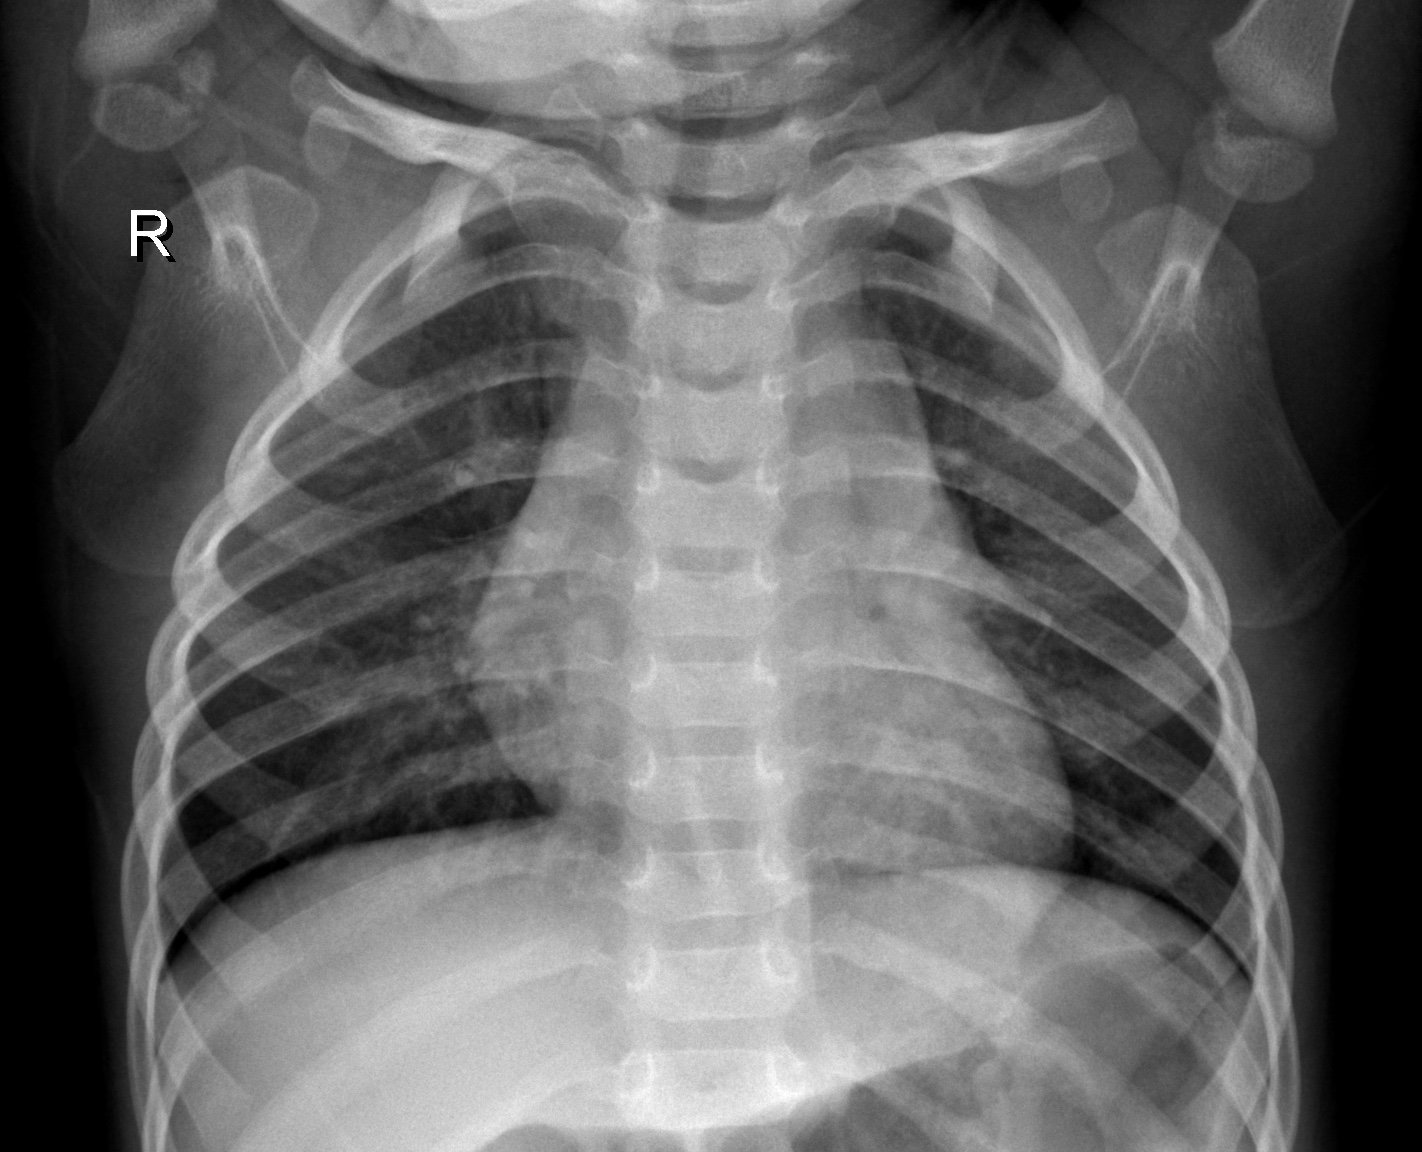

In [10]:
PIL.Image.open(train_norm_images[0])

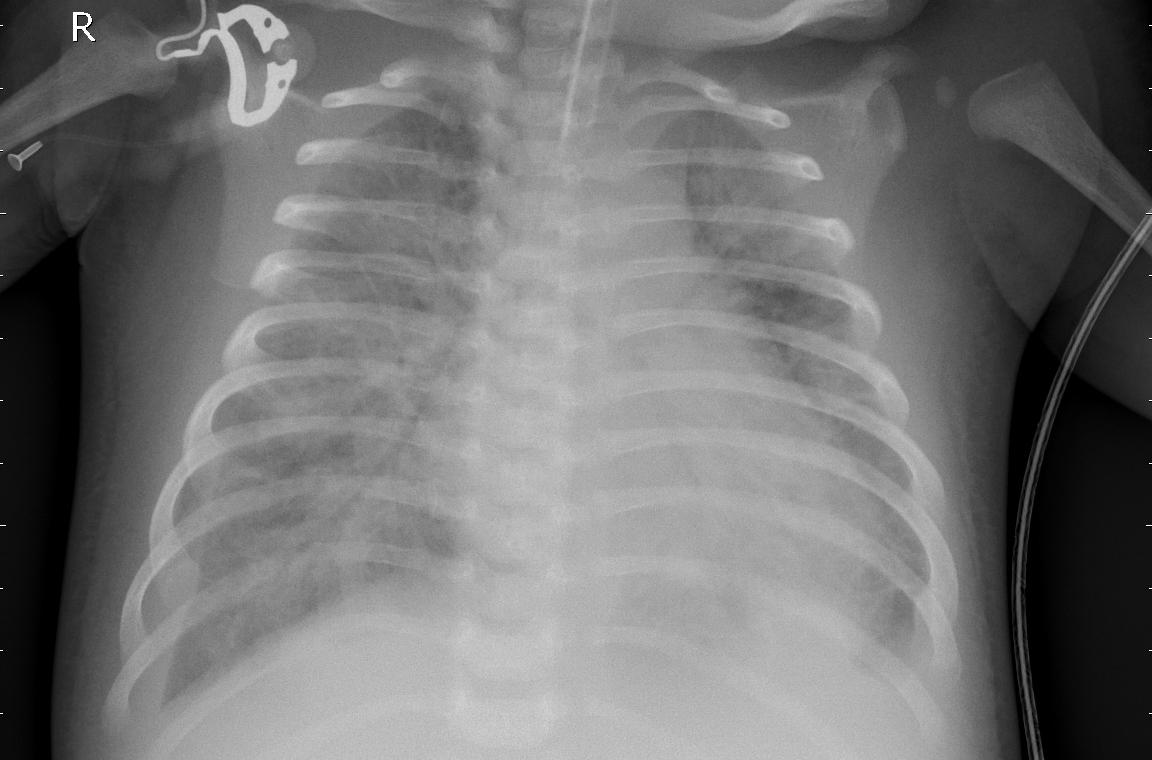

In [11]:
PIL.Image.open(train_pneu_images[0])

# Creating Test/Train Batches

In [12]:
# get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(256, 256), batch_size = 180) 

# get all the data in the directory split/validation (200 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(256, 256), batch_size = 200)

# get all the data in the directory split/train (542 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(256, 256), batch_size=542)

Found 624 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 4976 images belonging to 2 classes.


In [13]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

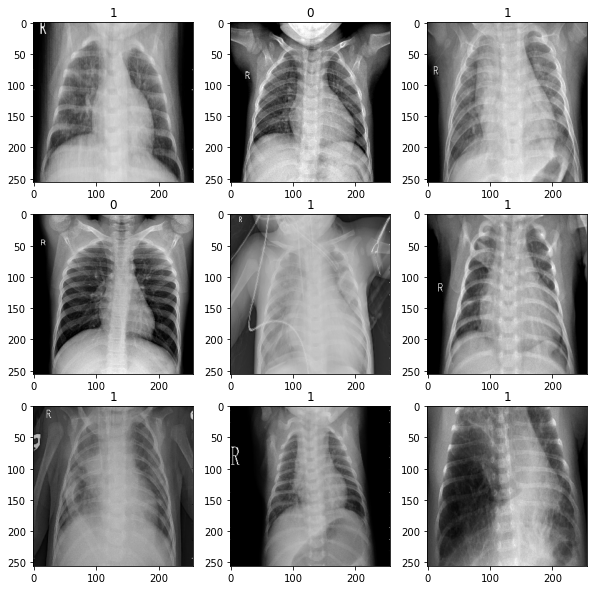

In [14]:
plt.figure(figsize=(10,10))

for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(array_to_img(train_images[i+250]))
    plt.title(int(train_labels[i+250][1]));

In [15]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 542
Number of testing samples: 180
Number of validation samples: 200
train_images shape: (542, 256, 256, 3)
train_labels shape: (542, 2)
test_images shape: (180, 256, 256, 3)
test_labels shape: (180, 2)
val_images shape: (200, 256, 256, 3)
val_labels shape: (200, 2)


In [16]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(542, 196608)
(180, 196608)
(200, 196608)


In [17]:
train_y = np.reshape(train_labels[:,0], (542,1))
test_y = np.reshape(test_labels[:,0], (180,1))
val_y = np.reshape(val_labels[:,0], (200,1))

# Baseline Model

In [18]:
baseline = models.Sequential()
baseline.add(layers.Dense(20, activation='relu', input_shape=(196608,))) # 2 hidden layers
baseline.add(layers.Dense(7, activation='relu'))
baseline.add(layers.Dense(5, activation='relu'))
baseline.add(layers.Dense(1, activation='sigmoid'))

In [19]:
baseline.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

baseline_history = baseline.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
17/17 [==============================] - 2s 69ms/step - loss: 1.7221 - accuracy: 0.6384 - val_loss: 0.7609 - val_accuracy: 0.5200
Epoch 2/50
17/17 [==============================] - 1s 52ms/step - loss: 0.4757 - accuracy: 0.7731 - val_loss: 0.5242 - val_accuracy: 0.7750
Epoch 3/50
17/17 [==============================] - 1s 52ms/step - loss: 0.3619 - accuracy: 0.8690 - val_loss: 0.4771 - val_accuracy: 0.8200
Epoch 4/50
17/17 [==============================] - 1s 52ms/step - loss: 0.3225 - accuracy: 0.8838 - val_loss: 0.4443 - val_accuracy: 0.8250
Epoch 5/50
17/17 [==============================] - 1s 52ms/step - loss: 0.2934 - accuracy: 0.8948 - val_loss: 0.5475 - val_accuracy: 0.7000
Epoch 6/50
17/17 [==============================] - 1s 51ms/step - loss: 0.2720 - accuracy: 0.8856 - val_loss: 0.4245 - val_accuracy: 0.8000
Epoch 7/50
17/17 [==============================] - 1s 52ms/step - loss: 0.2404 - accuracy: 0.9133 - val_loss: 0.6060 - val_accuracy: 0.6650
Epoch 8/50
17

In [20]:
results_train = baseline.evaluate(train_img, train_y)

17/17 [==============================] - 1s 29ms/step - loss: 0.0281 - accuracy: 0.9963


In [21]:
results_test = baseline.evaluate(test_img, test_y)

6/6 [==============================] - 0s 27ms/step - loss: 1.0331 - accuracy: 0.7278


In [22]:
results_test

[1.0330537557601929, 0.7277777791023254]

In [23]:
visualizer(baseline, filename='graphs/baseline', format='png')

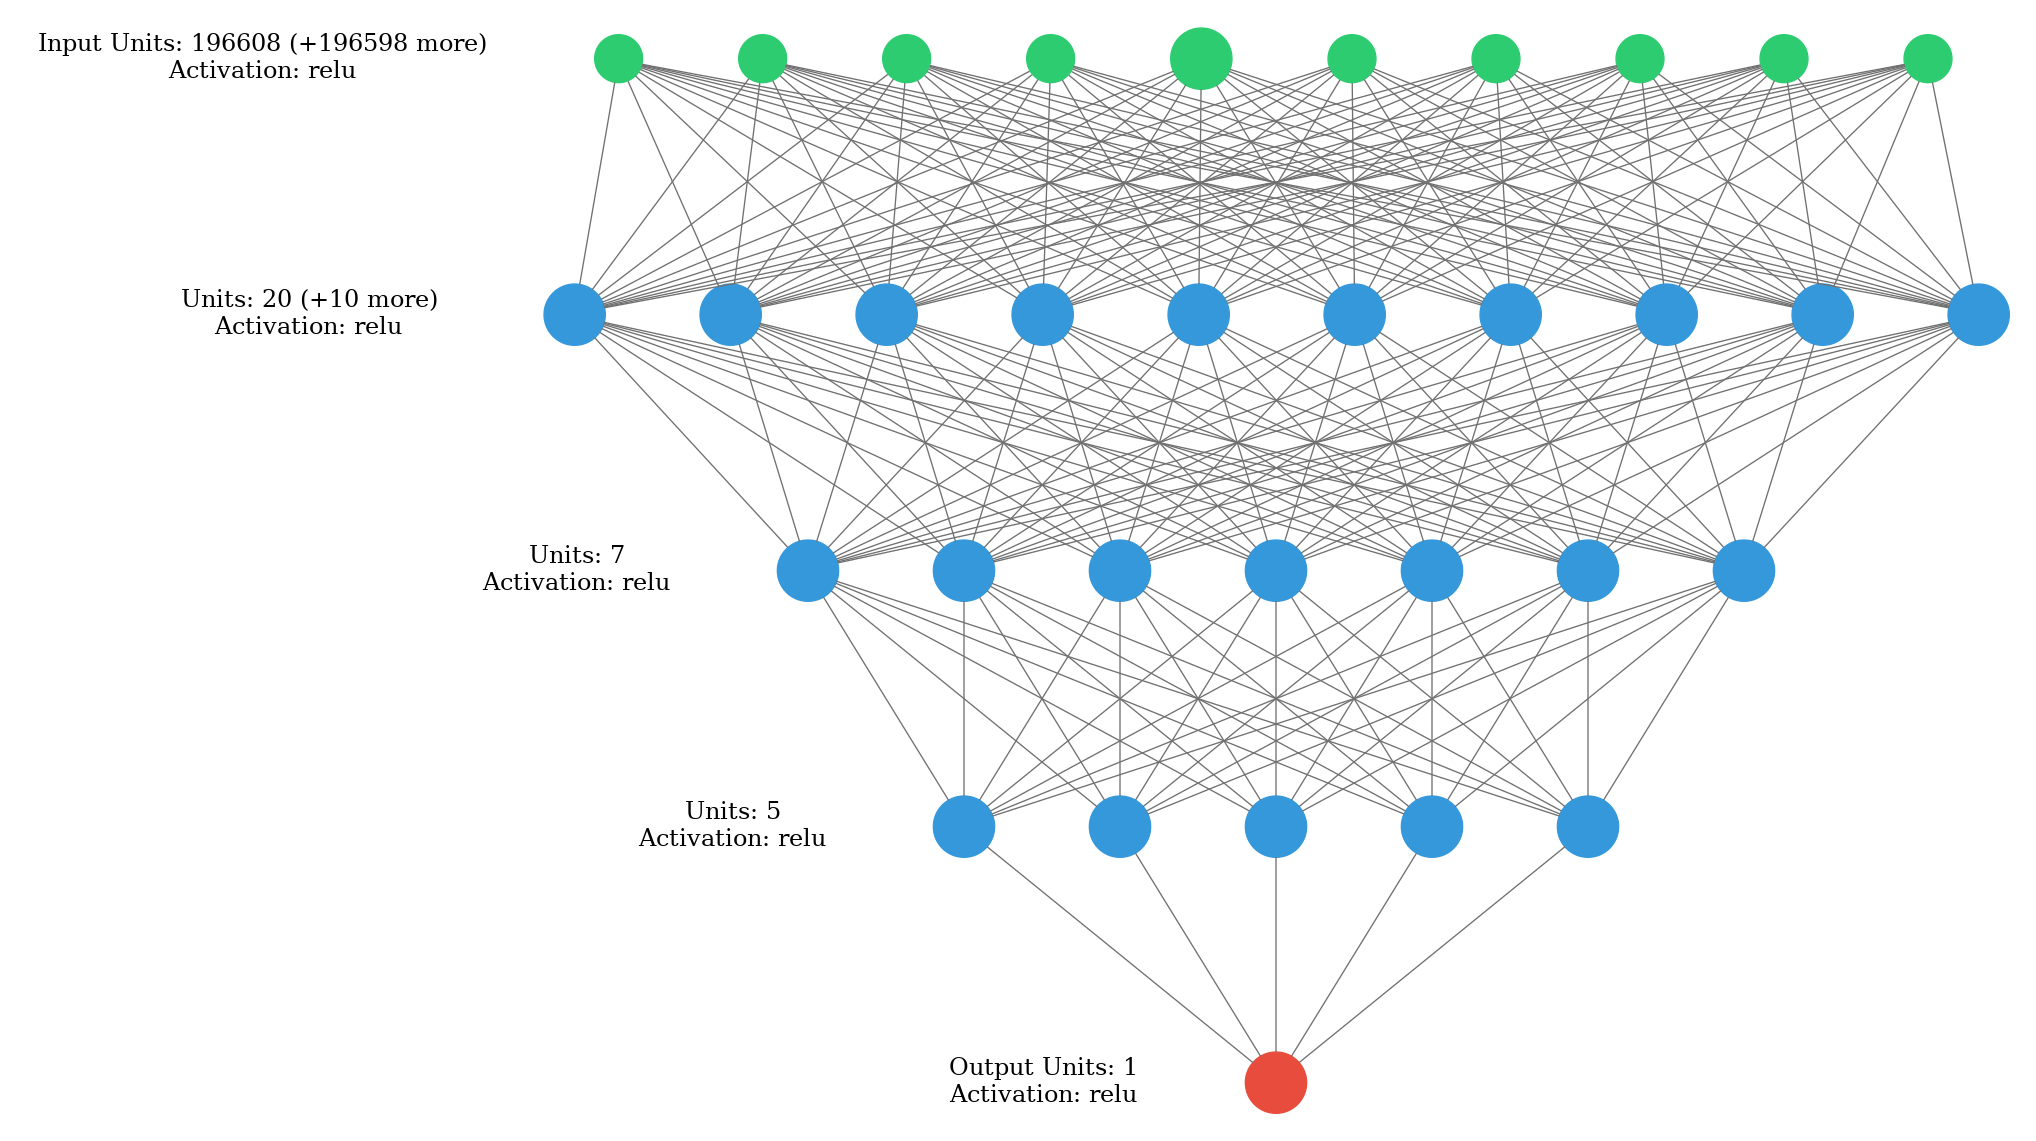

In [24]:
Image('graphs/baseline.png')

Build your own CNN

In [38]:
cnn1 = models.Sequential()
cnn1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(64, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

cnn1.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [39]:
cnn1_history = cnn1.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=16,
                    validation_data=(val_images, val_y))

Epoch 1/30
34/34 [==============================] - 15s 377ms/step - loss: 0.5660 - acc: 0.7528 - val_loss: 0.5776 - val_acc: 0.7050
Epoch 2/30
34/34 [==============================] - 11s 315ms/step - loss: 0.3388 - acc: 0.8745 - val_loss: 0.4339 - val_acc: 0.7650
Epoch 3/30
34/34 [==============================] - 11s 313ms/step - loss: 0.2757 - acc: 0.8672 - val_loss: 0.2891 - val_acc: 0.8800
Epoch 4/30
34/34 [==============================] - 11s 312ms/step - loss: 0.1909 - acc: 0.9188 - val_loss: 0.2288 - val_acc: 0.9000
Epoch 5/30
34/34 [==============================] - 11s 313ms/step - loss: 0.1145 - acc: 0.9576 - val_loss: 0.2398 - val_acc: 0.9100
Epoch 6/30
34/34 [==============================] - 11s 314ms/step - loss: 0.0824 - acc: 0.9760 - val_loss: 0.2260 - val_acc: 0.9050
Epoch 7/30
34/34 [==============================] - 11s 313ms/step - loss: 0.0471 - acc: 0.9871 - val_loss: 0.2118 - val_acc: 0.9250
Epoch 8/30
34/34 [==============================] - 11s 313ms/step - 

In [40]:
results_train = cnn1.evaluate(train_images, train_y)

17/17 [==============================] - 3s 163ms/step - loss: 3.3733e-05 - acc: 1.0000


In [41]:
results_test = cnn1.evaluate(test_images, test_y)

6/6 [==============================] - 1s 150ms/step - loss: 2.9182 - acc: 0.7167


In [42]:
visualizer(cnn1, filename='graphs/cnn1', format='png')

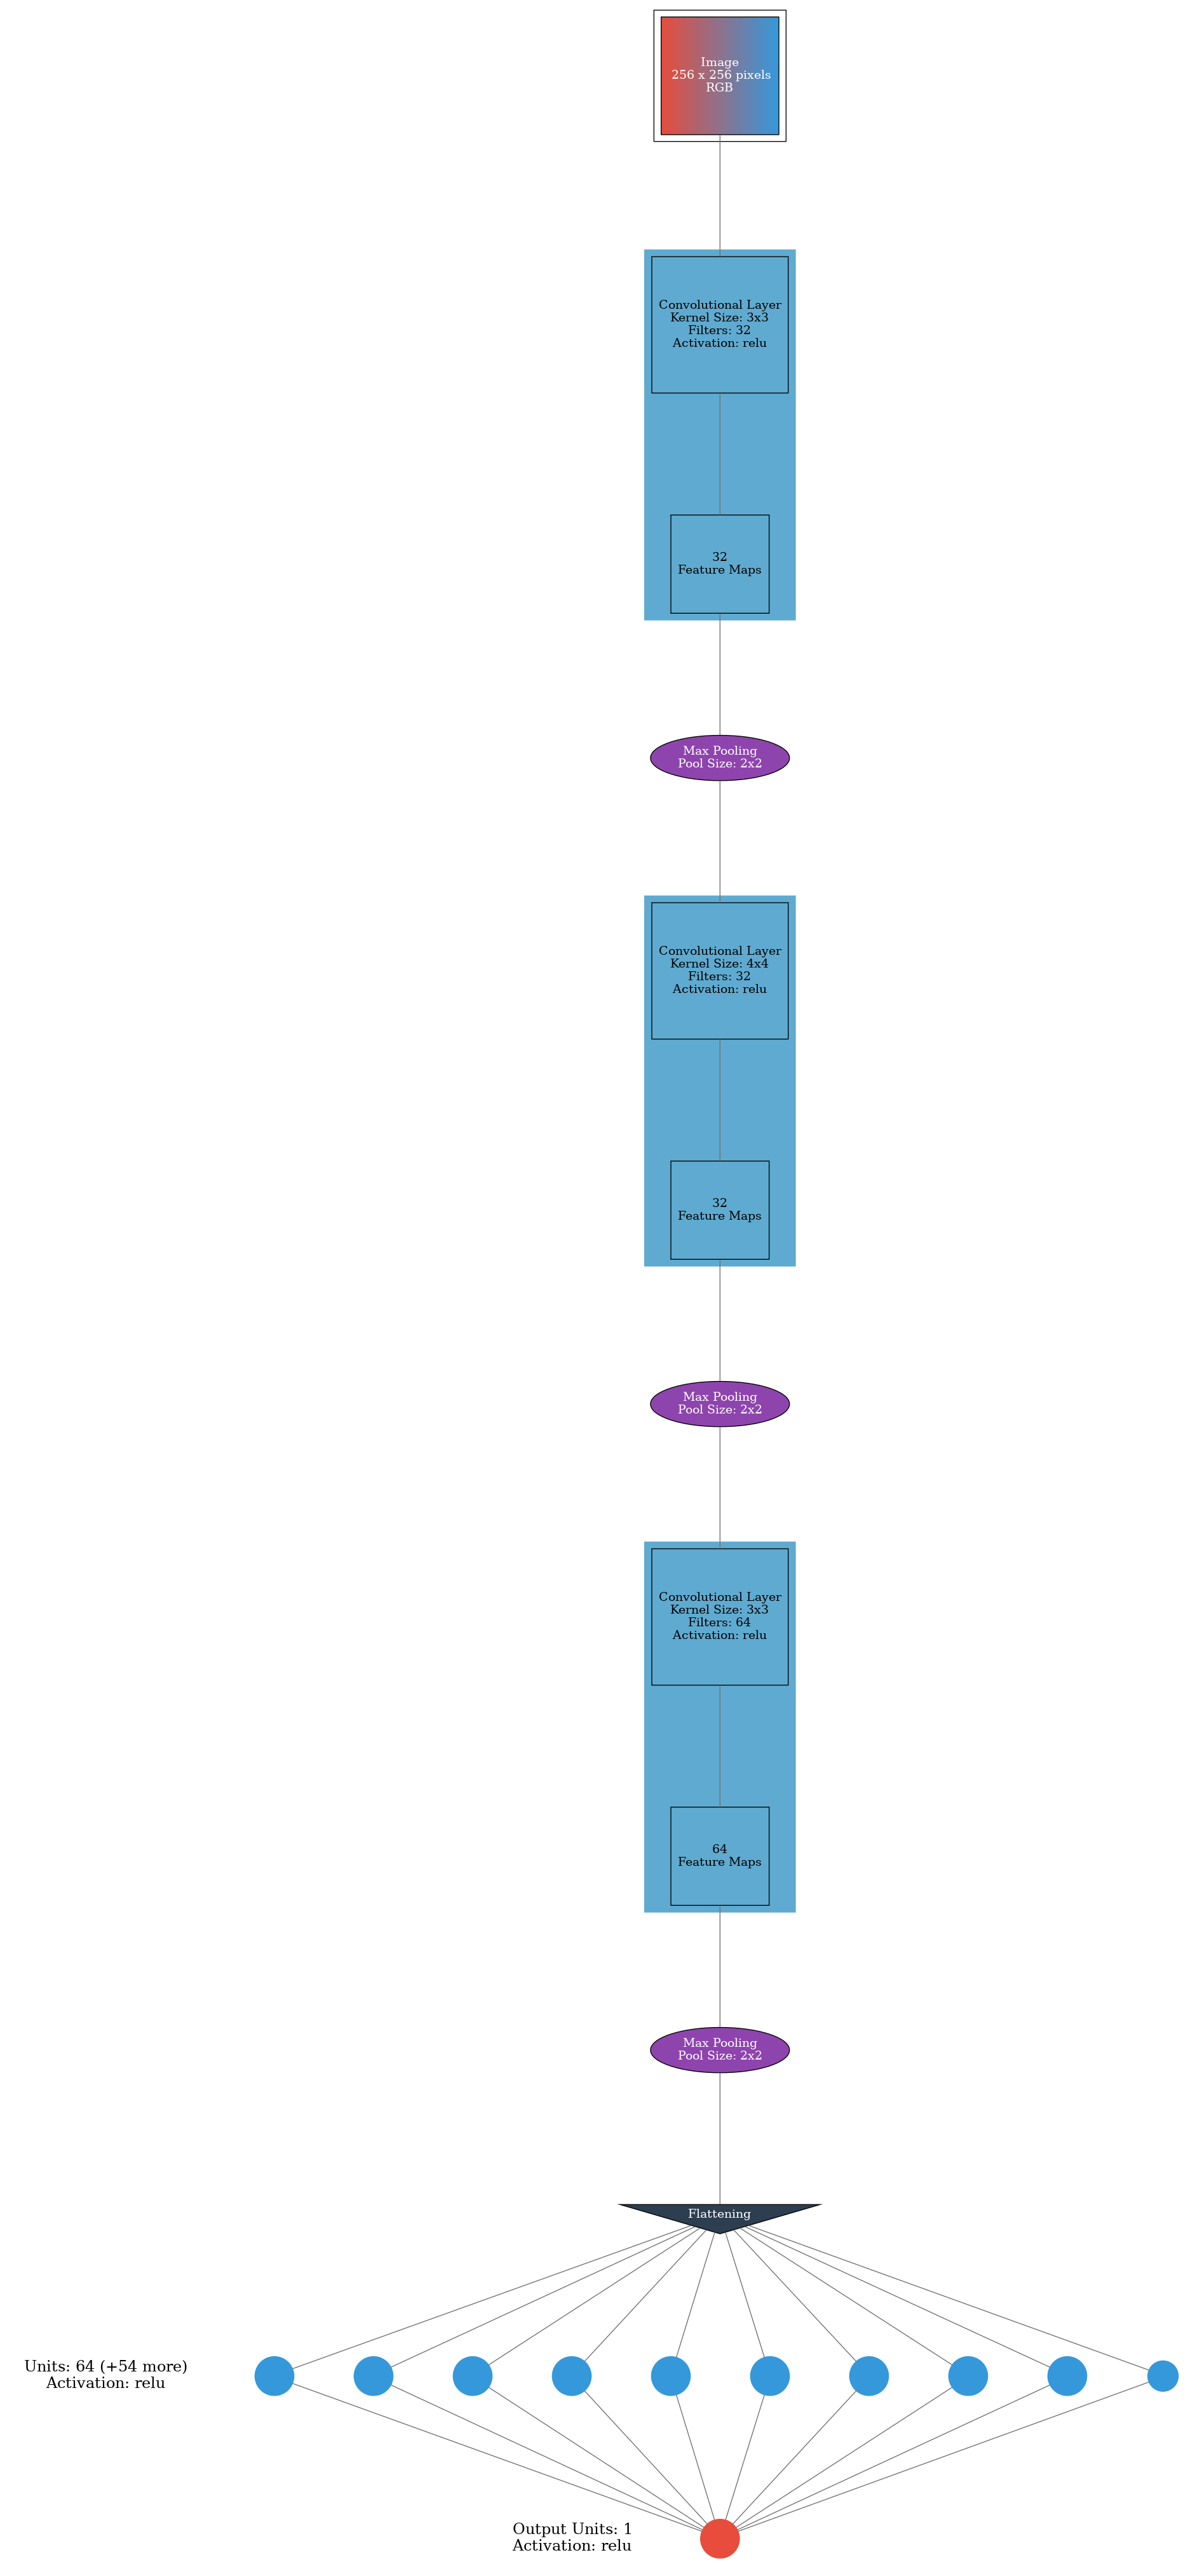

In [43]:
Image('graphs/cnn1.png')